# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.gradient.toolbox import column_stack
from pymoo.visualization.scatter import Scatter
from pyrecorder.recorder import Recorder
from pyrecorder.writers.video import Video

# Hyperparamters

In [2]:
P_MUTATION = 0.1
POPULATION_SIZE = 1000
ITERATIONS_NUM = 100
S = 1.5

# Method 1: Solve the problem using pymoo library

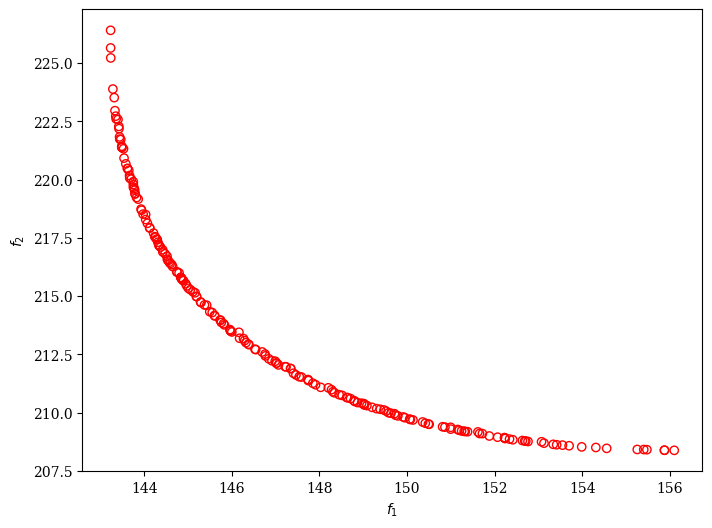

In [3]:
class Cones(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_ieq_constr=1, xl=np.array([0, 0]), xu=np.array([10, 20]), vtype=float)

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = np.pi * x[:, 0] * np.sqrt(x[:, 0] ** 2 + x[:, 1] ** 2)
        f2 = np.pi * x[:, 0] ** 2 + f1
        out["F"] = column_stack([f1, f2])
        out["G"] = -1 / 200 * (np.pi * x[:, 0] ** 2 * x[:, 1] / 3 - 200)

problem = Cones()
algorithm = NSGA2(pop_size=POPULATION_SIZE)

res = minimize(problem=problem, algorithm=algorithm, termination=('n_gen', ITERATIONS_NUM), save_history=True, seed=1, verbose=False)


with Recorder(Video("pareto_front_per_generation_NSGA2.mp4", fps=5)) as rec:
    for entry in res.history:
        sc = Scatter(title=(f"Gen {entry.n_gen}"))
        sc.add(entry.pop.get("F"), facecolor="none", edgecolor="red")
        sc.do()
        rec.record()

plot = Scatter()
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

# Method 2: Solve the problem by implementing everything from scratch

## Individual, Fitness, Mutations, and crossovers

In [4]:
class Individual:
    def __init__(self, chromosome: np.ndarray):
        assert 0 <= chromosome[0] <= 10 and 0 <= chromosome[1] <= 20
        self.chromosome = np.append(np.append(chromosome, 1), 1) if len(chromosome) == 2 else chromosome
        self.objectives = None
        self.num_dominated = None # Number of indivisuals that dominate this individual
    
    def calc_objectives(self) -> np.ndarray:
        r = self.chromosome[0]
        h = self.chromosome[1]
        s = np.sqrt(r**2 + h**2)
        B = np.pi * r**2
        S = np.pi * r * s
        T = B + S
        self.objectives = np.array([S, T])
        return self.objectives
    
    def is_feasible(self):
        r = self.chromosome[0]
        h = self.chromosome[1]
        V = np.pi * r**2 * h / 3
        return V > 200
    
    def mutate(self):
        offspring = self.chromosome.copy()
        offspring[2] += offspring[2] * np.random.randn()
        offspring[3] += offspring[3] * np.random.randn()
        offspring[0] += offspring[2] * np.random.randn()
        offspring[1] += offspring[3] * np.random.randn()
        offspring = Individual(np.clip(a=offspring, a_min=[0, 0, 0.1, 0.2], a_max=[10, 20, 4, 8]))
        return offspring
    
    @staticmethod
    def blend_crossover(parent1, parent2, alpha=0.5):
        parent1_chromosome = parent1.chromosome.copy()
        parent2_chromosome = parent2.chromosome.copy()
        offspring1 = parent1_chromosome.copy()
        offspring2 = parent2_chromosome.copy()
        d = parent2_chromosome[parent1_chromosome < parent2_chromosome] - parent1_chromosome[parent1_chromosome < parent2_chromosome]
        offspring1[offspring1 < parent2_chromosome] = np.random.uniform(low=parent1_chromosome[parent1_chromosome < parent2_chromosome] - alpha*d, high=parent1_chromosome[parent1_chromosome < parent2_chromosome] + alpha*d)
        d = parent1_chromosome[parent2_chromosome < parent1_chromosome] - parent2_chromosome[parent2_chromosome < parent1_chromosome]
        offspring2[offspring2 < parent1_chromosome] = np.random.uniform(low=parent2_chromosome[parent2_chromosome < parent1_chromosome] - alpha*d, high=parent2_chromosome[parent2_chromosome < parent1_chromosome] + alpha*d)
        offspring1 = Individual(np.clip(a=offspring1, a_min=[0, 0, 0.1, 0.2], a_max=[10, 20, 4, 8]))
        offspring2 = Individual(np.clip(a=offspring2, a_min=[0, 0, 0.1, 0.2], a_max=[10, 20, 4, 8]))
        return offspring1, offspring2
    
    @staticmethod
    def whole_arithmetic_crossover(parent1, parent2, alpha=0.5):
        offspring1 = Individual(alpha*parent1.chromosome + (1-alpha)*parent2.chromosome)
        offspring2 = Individual(alpha*parent2.chromosome + (1-alpha)*parent1.chromosome)
        return offspring1, offspring2

    @staticmethod
    def calc_num_dominated(individuals_list):
        for i in range(len(individuals_list)):
            individuals_list[i].num_dominated = 0
            for j in range(len(individuals_list)):
                if np.all(individuals_list[j].objectives <= individuals_list[i].objectives):
                    individuals_list[i].num_dominated += 1
    
    def __str__(self):
        return f'Chromosome: [{np.round(self.chromosome[0], 6):09.6f}, {np.round(self.chromosome[1], 6):09.6f}, {np.round(self.chromosome[2], 6):09.6f}, {np.round(self.chromosome[3], 6):09.6f}]; Objectives: [{np.round(self.objectives[0], 6):011.6f}, {np.round(self.objectives[1], 6):011.6f}];\nNum_dominated: {self.num_dominated:04}'
    
    def __repr__(self):
        return f'Chromosome: [{np.round(self.chromosome[0], 6):09.6f}, {np.round(self.chromosome[1], 6):09.6f}, {np.round(self.chromosome[2], 6):09.6f}, {np.round(self.chromosome[3], 6):09.6f}]; Objectives: [{np.round(self.objectives[0], 6):011.6f}, {np.round(self.objectives[1], 6):011.6f}];\nNum_dominated: {self.num_dominated:04}'

## Parent and survival selection function

In [5]:
def linear_ranking(individuals_list: list[Individual], s=1.5):
    population_size = len(individuals_list)
    individuals_probs = []
    individuals_sorted = sorted(individuals_list, key=lambda x: x.num_dominated, reverse=True)
    for individual in individuals_list:
        i = individuals_sorted.index(individual)
        individuals_probs.append((2-s) / population_size + (2*i*(s-1)) / (population_size*(population_size-1)))
    return individuals_probs

## Initialization

In [6]:
def initialize_population(population_size: int):
    individuals_list = []
    i = 0
    while i < population_size:
        individual = Individual(np.array([np.random.uniform(low=0, high=10), np.random.uniform(low=0, high=20)]))
        if not individual.is_feasible():
            continue
        individual.calc_objectives()
        individuals_list.append(individual)
        i += 1
    Individual.calc_num_dominated(individuals_list)
    return individuals_list

## Running the algorithm

In [9]:
def run_algorithm(population_size: int, iterations_num: int, p_mutation: float, s=1.5):
    individuals_list = initialize_population(population_size)
    non_dominated_individuals = [[] for _ in range(iterations_num+1)]
    non_dominated_individuals[0] = [individual for individual in individuals_list if individual.num_dominated == 1]
    for generation in tqdm(range(iterations_num)):
        # assign selection probability to each individual
        individuals_probs = linear_ranking(individuals_list, s=s)

        # do crossover and mutation
        offsprings_list = []
        for _ in range((3*population_size)//2):
            while True:
                parent1, parent2 = np.random.choice(individuals_list, size=2, replace=False, p=individuals_probs)
                temp1, temp2 = Individual.blend_crossover(parent1, parent2)
                if temp1.is_feasible() and temp2.is_feasible():
                    break
            temp1.calc_objectives()
            temp2.calc_objectives()
            offsprings_list += [temp1, temp2]
        for offspring in offsprings_list:
            if np.random.rand() <= p_mutation:
                while True:
                    temp = offspring.mutate()
                    if temp.is_feasible():
                        break
                temp.calc_objectives()
                offsprings_list.append(temp)
                
        # assign selection probability to each individual
        temp = offsprings_list + individuals_list
        Individual.calc_num_dominated(temp)
        parents_offsprings = [individual for individual in temp if individual.num_dominated > 1]
        non_dominated_individuals[generation+1] = [individual for individual in temp if individual.num_dominated == 1]
        individuals_list = non_dominated_individuals[generation+1] + list(np.random.choice(parents_offsprings, size=population_size-len(non_dominated_individuals[generation+1]), replace=False))

    return individuals_list, non_dominated_individuals

In [10]:
individuals_list, non_dominated_individuals = run_algorithm(population_size=POPULATION_SIZE, iterations_num=ITERATIONS_NUM, p_mutation=P_MUTATION, s=S)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [2:00:26<00:00, 72.27s/it]


## Results and Visualizations

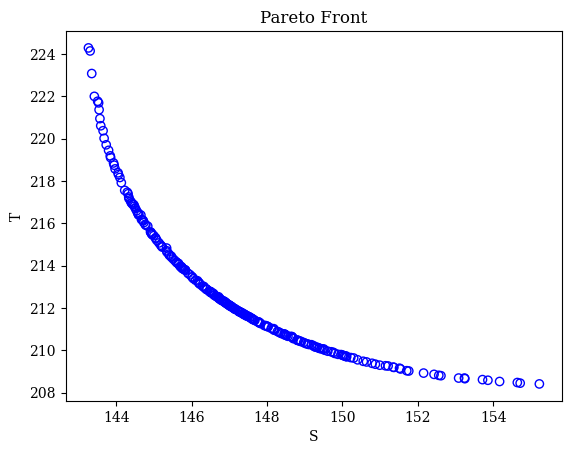

In [28]:
plt.scatter([individual.objectives[0] for individual in non_dominated_individuals[-1]], [individual.objectives[1] for individual in non_dominated_individuals[-1]], facecolor="none", edgecolor="blue")
plt.xlabel('S')
plt.ylabel('T')
plt.title('Pareto Front')
plt.show()

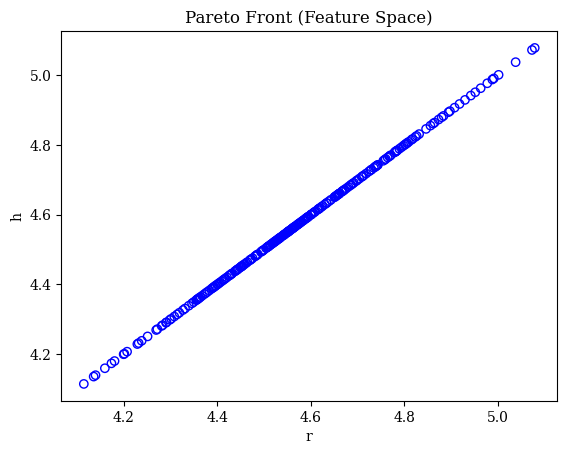

In [36]:
plt.scatter([individual.chromosome[0] for individual in non_dominated_individuals[-1]], [individual.chromosome[0] for individual in non_dominated_individuals[-1]], facecolor="none", edgecolor="blue")
plt.xlabel('r')
plt.ylabel('h')
plt.title('Pareto Front (Feature Space)')
plt.show()

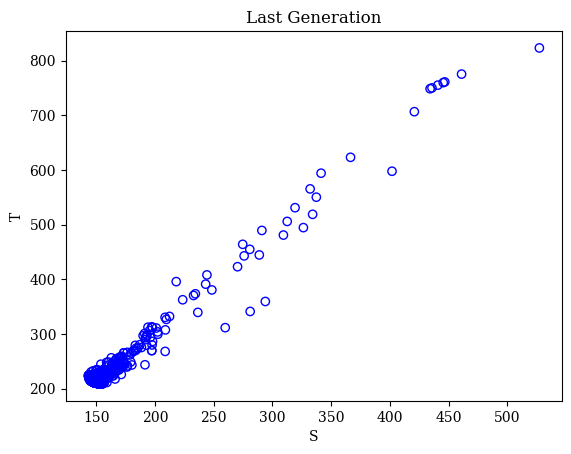

In [29]:
plt.scatter([individual.objectives[0] for individual in individuals_list], [individual.objectives[1] for individual in individuals_list], facecolor="none", edgecolor="blue")
plt.xlabel('S')
plt.ylabel('T')
plt.title('Last Generation')
plt.show()

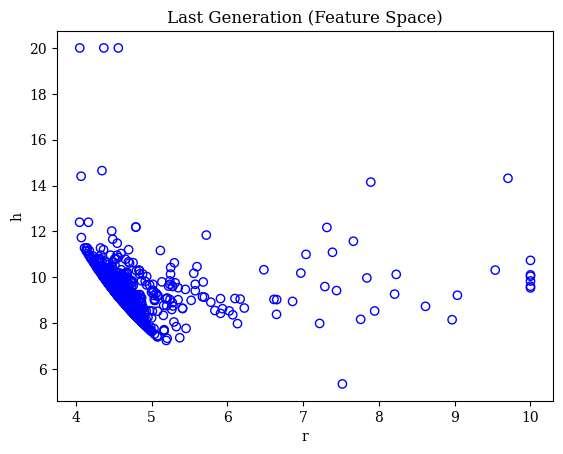

In [38]:
plt.scatter([individual.chromosome[0] for individual in individuals_list], [individual.chromosome[1] for individual in individuals_list], facecolor="none", edgecolor="blue")
plt.xlabel('r')
plt.ylabel('h')
plt.title('Last Generation (Feature Space)')
plt.show()

In [39]:
print(f"Number of non-dominated individuals in the last generation is {len(non_dominated_individuals[-1])}/1000.")

Number of non-dominated individuals in the last generation is 254/1000.


In [31]:
with Recorder(Video("pareto_front_per_generation_my_implementation.mp4", fps=5)) as rec:
    for generation, pareto_front in enumerate(non_dominated_individuals):
        plt.scatter([individual.objectives[0] for individual in pareto_front], [individual.objectives[1] for individual in pareto_front], facecolor="none", edgecolor="blue")
        plt.xlabel('S')
        plt.ylabel('T')
        plt.title('Pareto Front')
        rec.record()